In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/weather-dataset


In [3]:
# 1. Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


# Set to match kagglehub's default
data_dir = '/kaggle/input/weather-dataset/dataset'
print("Dataset classes (subfolders):", os.listdir(data_dir))

# Basic hyperparameters
batch_size = 16
num_epochs = 10
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Dataset classes (subfolders): ['hail', 'rainbow', 'frost', 'rime', 'fogsmog', 'snow', 'rain', 'glaze', 'lightning', 'sandstorm', 'dew']


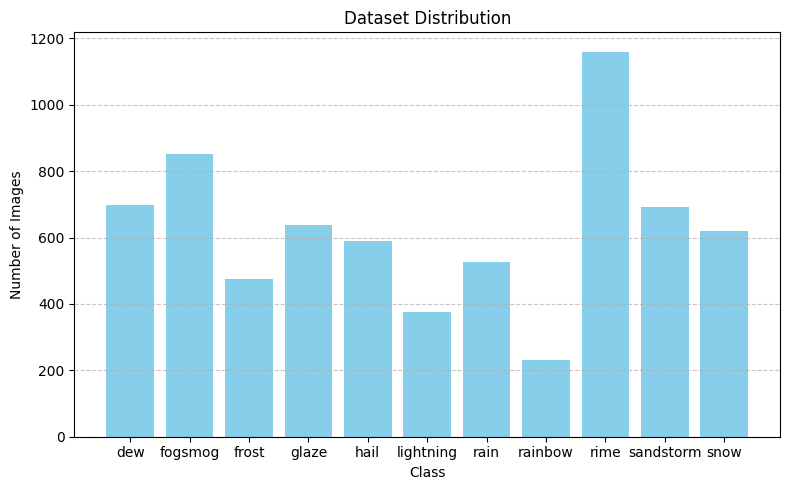

In [4]:
# 2. Visualize Class Distribution
class_counts = {}
for class_name in sorted(os.listdir(data_dir)):
    folder = os.path.join(data_dir, class_name)
    if os.path.isdir(folder):
        images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(images)

plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [5]:
# 3. Transforms and DataLoaders

# Augmentation for training, basic normalization for testing
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, shear=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# For evaluation, use same normalization only
test_dataset = datasets.ImageFolder(data_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Num train samples:", len(train_dataset))
print("Num val samples:", len(val_dataset))
print("Num test samples:", len(test_dataset))
print("Classes:", full_dataset.classes)
num_classes = len(full_dataset.classes)


Num train samples: 5489
Num val samples: 1373
Num test samples: 6862
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [6]:
# 4. Model: EfficientNetV2S with Custom Classifier

from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 188MB/s]


In [8]:
from tqdm.notebook import tqdm

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        # Optional: show batch loss in tqdm description
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation step
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss {train_loss:.4f}, Acc {train_acc*100:.2f}% | "
          f"Val Loss {val_loss:.4f}, Acc {val_acc*100:.2f}%")

print("Training complete.")


Epoch 1/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.5512, Acc 82.66% | Val Loss 0.3425, Acc 89.80%


Epoch 2/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 2: Train Loss 0.4283, Acc 86.26% | Val Loss 0.3539, Acc 88.71%


Epoch 3/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 3: Train Loss 0.3765, Acc 87.88% | Val Loss 0.3082, Acc 90.68%


Epoch 4/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 4: Train Loss 0.3387, Acc 89.03% | Val Loss 0.3007, Acc 89.08%


Epoch 5/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 5: Train Loss 0.2980, Acc 90.42% | Val Loss 0.4256, Acc 86.53%


Epoch 6/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 6: Train Loss 0.2752, Acc 90.75% | Val Loss 0.2934, Acc 90.39%


Epoch 7/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 7: Train Loss 0.2541, Acc 91.86% | Val Loss 0.2721, Acc 91.33%


Epoch 8/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 8: Train Loss 0.2352, Acc 92.64% | Val Loss 0.2877, Acc 90.68%


Epoch 9/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 9: Train Loss 0.2242, Acc 92.64% | Val Loss 0.3188, Acc 90.02%


Epoch 10/10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 10: Train Loss 0.2237, Acc 92.77% | Val Loss 0.2816, Acc 91.19%
Training complete.


In [9]:
# Save the trained model's weights
model_save_path = 'efficientnet_v2_s_weather.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved as {model_save_path}")


Model saved as efficientnet_v2_s_weather.pth


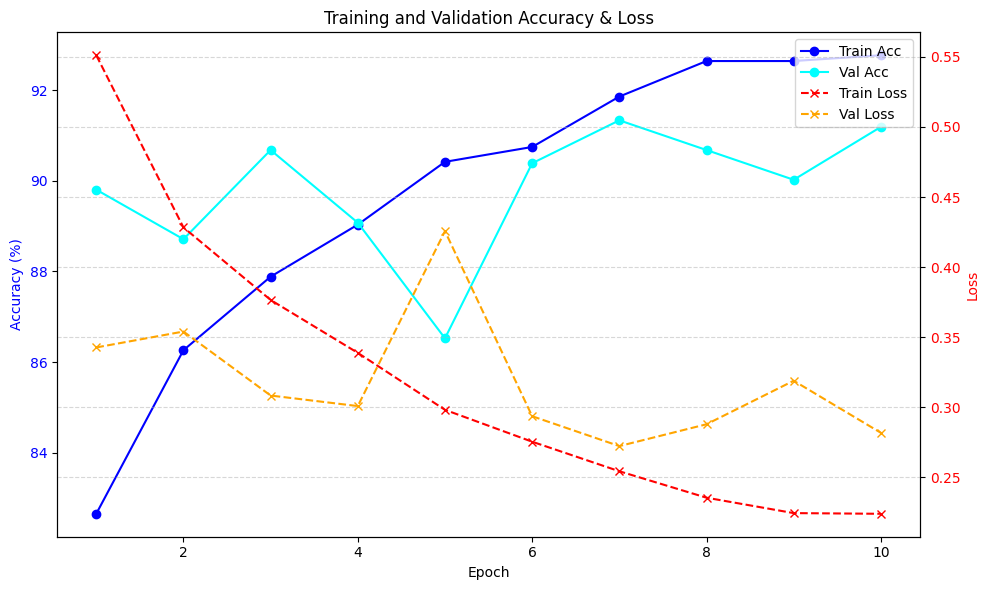

In [10]:
# 6. Plot Training Curves
epochs = list(range(1, num_epochs+1))
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)', color='blue')
ax1.plot(epochs, [a*100 for a in train_accs], marker='o', linestyle='-', color='b', label='Train Acc')
ax1.plot(epochs, [a*100 for a in val_accs], marker='o', linestyle='-', color='cyan', label='Val Acc')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, train_losses, marker='x', linestyle='--', color='red', label='Train Loss')
ax2.plot(epochs, val_losses, marker='x', linestyle='--', color='orange', label='Val Loss')
ax2.tick_params(axis='y', labelcolor='red')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.title('Training and Validation Accuracy & Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [11]:
# 7. Final Test Set Evaluation

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
test_acc = correct / total
print(f"Test accuracy: {test_acc*100:.2f}%")


Test accuracy: 97.20%


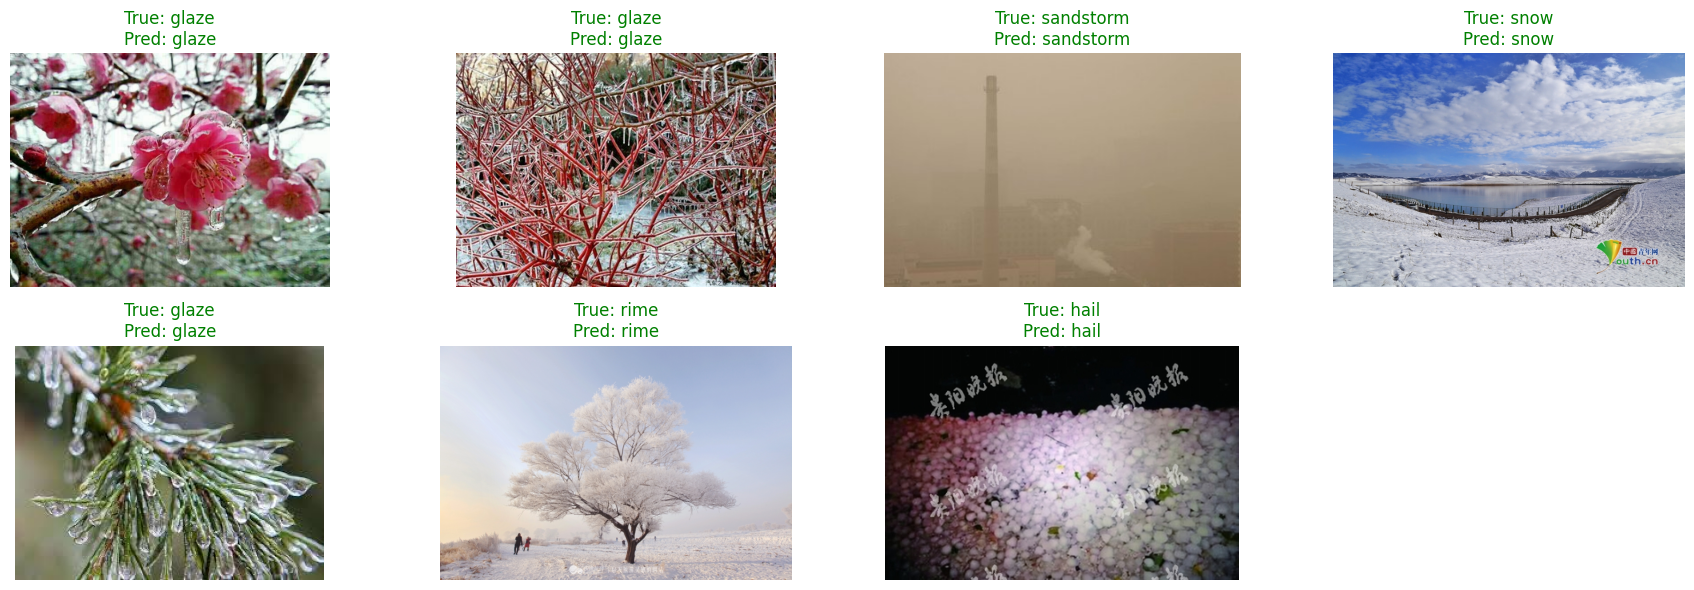

In [12]:
import os
import random
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models import efficientnet_v2_s
import matplotlib.pyplot as plt

# --- Configurations ---
data_dir = '/kaggle/input/weather-dataset/dataset'  # Root of all category folders
model_path = '/content/efficientnet_v2_s_weather.pth'   # Update for your model path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get class names from subfolders
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
num_classes = len(class_names)

# -- Load the model --
model = efficientnet_v2_s(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# -- Image transform (should match your train/test pipeline) --
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# -- Collect random images from all categories --
all_paths = []
for cat in class_names:
    cat_folder = os.path.join(data_dir, cat)
    images = [os.path.join(cat_folder, f) for f in os.listdir(cat_folder)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    all_paths.extend([(img, cat) for img in images])

chosen = random.sample(all_paths, 7) if len(all_paths) >= 7 else all_paths

# -- Predict and show images --
plt.figure(figsize=(18,6))
for idx, (img_path, true_cat) in enumerate(chosen):
    img = Image.open(img_path).convert('RGB')
    inp = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(inp)
        pred_idx = out.argmax(dim=1).item()
    pred_label = class_names[pred_idx]
    plt.subplot(2, 4, idx+1)
    plt.imshow(img)
    plt.title(f"True: {true_cat}\nPred: {pred_label}", color='green' if pred_label==true_cat else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()
